In [12]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf#acf和pacf展示库
from statsmodels.tsa.stattools import adfuller#adf检验库
from statsmodels.stats.diagnostic import acorr_ljungbox#随机性检验库
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import prettytable 

In [13]:
def pre_table(table_name,table_rows):
    table=prettytable.PrettyTable()
    table.field_names=table_name
    for i in table_rows:
        table.add_row(i)
    return table

In [14]:
def get_best_log(ts,max_log=5,rule1=True,rule2=True):
    if rule1 and rule2:
        return 0, ts
    else:
        for i in range(1,max_log):
            ts=np.log(ts)
            lbvalue,pvalue2=acorr_ljungbox(ts,lags=1) #延迟期数=1，可以自定义6，12等
            adf,pvalue1,usedlag,nobs,critical_values,icbest=adfuller(ts)
            rule_1=(adf<critical_values['1%'] and adf <critical_values['5%']
                   and adf<critical_values['10%'] and pvalue1<0.01)
            rule_2=(pvalue2<0.05)
            rule_3=(i<5)
            if rule_1 and rule_2 and rule_3:
                print ('The best log n is :{0}'.format(i) )
            return i ,ts

In [15]:
def recover_log(ts,log_n):
    for i in range(1,log_n+1):
        ts=np.exp(ts)
        return ts

In [16]:
def adf_val(ts,ts_title,acf_title,pacf_title):
    plt.figure()
    plt.plot(ts)
    plt.title(ts_title)
    plt.show()
    plot_acf(ts,lags=20,title=acf_title).show()
    plot_pacf(ts,lags=20,title=pacf_title).show()
    adf,pvalue,usedlag,nobs,critical_values,icbest=adfuller(ts)
    table_name=['adf','pvalue','usedlag','nobs','critical_values','icbest']
    table_rows=[[adf,pvalue,usedlag,nobs,critical_values,icbest]]
    adf_table=pre_table(table_name,table_rows)
    print ('stochastic score')
    print (adf_table)
    return adf,pvalue,critical_values

In [17]:
def acorr_val(ts):
    lbvalue,pvalue=acorr_ljungbox(ts,lags=1)
    table_name=['lbvalue','pvalue']
    table_rows=[[lbvalue,pvalue]]
    acorr_ljungbox_table=pre_table(table_name,table_rows)
    print ('stationary score')
    print (acorr_ljungbox_table)
    return pvalue

In [18]:
def arma_fit(ts):
    max_count=int(len(ts)/10)
    bic=float('inf')
    tmp_score=[]
    for tmp_p in range(max_count+1):
        for tmp_q in range(max_count+1):
            model=ARMA(ts,order=(tmp_p,tmp_q))
            try:
                results_ARMA=model.fit(disp=-1,method='css')
            except:
                continue
            finally:
                tmp_aic=results_ARMA.aic
                tmp_bic=results_ARMA.bic
                tmp_hqic=results_ARMA.hqic
                tmp_score.append([tmp_p,tmp_q,tmp_aic,tmp_bic,tmp_hqic])
                if tmp_bic<bic:
                    p=tmp_p
                    q=tmp_q
                    model_arma=results_ARMA
                    aic=tmp_aic
                    bic=tmp_bic
                    hqic=tmp_hqic
    pdq_metrix=np.array(tmp_score)
    pdq_pd=pd.DataFrame(pdq_metrix,columns=['p','q','aic','bic','hqic'])
    table_name=['p','q','aic','bic','hqic']
    table_rows=[[p,q,aic,bic,hqic]]
    parameter_table=pre_table(table_name,table_rows)
    print('each p/q traning record')
    print (pdq_pd)
    print('best p and q')
    print (parameter_table)
    return model_arma

In [19]:
def train_test(model_arma,ts,log_n,rule1=True,rule2=True):
    train_predict=model_arma.predict()
    if not (rule1 and rule2):
        train_predict=recover_log(train_predict,log_n)
        ts=recover_log(ts,log_n)
    ts_data_new=ts[train_predict.index]
    RMSE=np.sqrt(np.sum((train_predict-ts_data_new)**2)/ts_data_new.size)
    plt.figure()
    train_predict.plot(label='predicted data',style='--')
    ts_data_new.plot(label='raw data')
    plt.legend(loc='best')
    plt.title('raw data and predicted data with RMSE of %.2f'%RMSE)
    plt.show()
    return ts

In [20]:
def predict_data(model_arma,ts,log_n,start,end,rule1=True,rule2=True):
    predict_ts=model_arma.predict(start=start,end=end)
    print('-----------predict date-----------')
    if not (rule1 and rule2):
        predict_ts=recover_log(predict_ts,log_n)
        print (predict_ts)
    plt.figure()
    ts.plot(label='raw time series')
    predict_ts.plot(label='predicted data',style='--')
    plt.legend(loc='best')
    plt.title('predicted time series')
    plt.show()

data summary
count    149.000000
mean     164.382553
std       75.097740
min       47.000000
25%      100.000000
50%      156.000000
75%      201.000000
max      400.000000
Name: number, dtype: float64


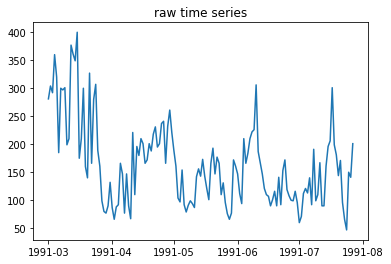

stochastic score
+---------------------+----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
|         adf         |        pvalue        | usedlag | nobs |                                  critical_values                                  |       icbest       |
+---------------------+----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
| -3.7642778196383455 | 0.003294690380296773 |    11   | 137  | {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603} | 1405.3846604574503 |
+---------------------+----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
stationary score
+-----------------------------------------------------------------+------------------------------------------------------

/Users/magictavern/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/magictavern/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


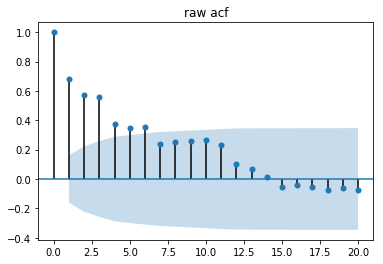

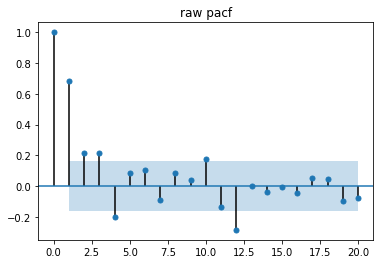

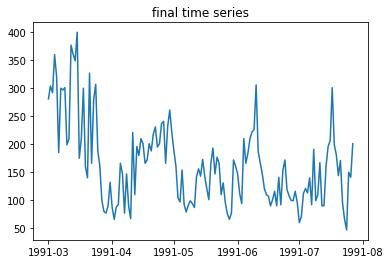

/Users/magictavern/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/magictavern/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error

stochastic score
+---------------------+----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
|         adf         |        pvalue        | usedlag | nobs |                                  critical_values                                  |       icbest       |
+---------------------+----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
| -3.7642778196383455 | 0.003294690380296773 |    11   | 137  | {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603} | 1405.3846604574503 |
+---------------------+----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
stationary score
+-----------------------------------------------------------------+------------------------------------------------------

/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so infe

/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so infe

/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so infe

/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_par

/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided

/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_par

/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed t

each p/q traning record
        p     q          aic          bic         hqic
0     0.0   0.0  1712.839862  1718.847755  1715.280770
1     0.0   1.0  1653.446702  1662.458541  1657.108063
2     0.0   2.0  1648.868523  1660.884308  1653.750338
3     0.0   3.0  1618.676555  1633.696287  1624.778824
4     0.0   4.0  1619.720071  1637.743748  1627.042793
5     0.0   5.0  1619.720071  1637.743748  1627.042793
6     0.0   6.0  1601.914727  1625.946297  1611.678357
7     0.0   7.0  1603.490230  1630.525746  1614.474313
8     0.0   8.0  1603.310918  1633.350381  1615.515455
9     0.0   9.0  1605.309821  1638.353230  1618.734812
10    0.0  10.0  1605.309821  1638.353230  1618.734812
11    0.0  11.0  1605.309821  1638.353230  1618.734812
12    0.0  12.0  1605.309821  1638.353230  1618.734812
13    0.0  13.0  1605.309821  1638.353230  1618.734812
14    0.0  14.0  1605.309821  1638.353230  1618.734812
15    1.0   0.0  1607.860643  1616.852280  1611.513924
16    1.0   1.0  1597.519474  1609.508323

/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/magictavern/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


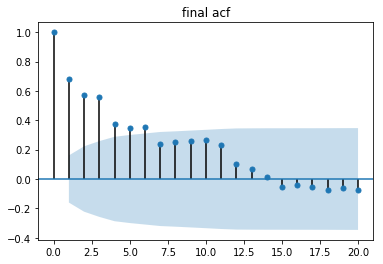

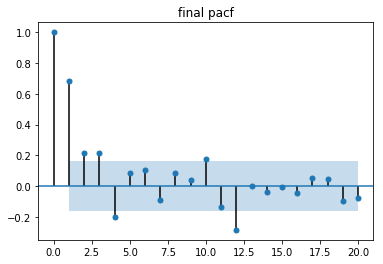

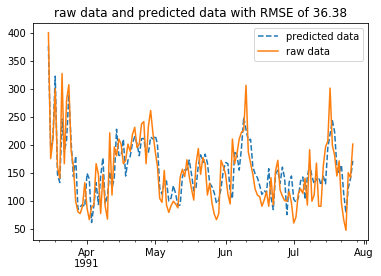

-----------predict date-----------


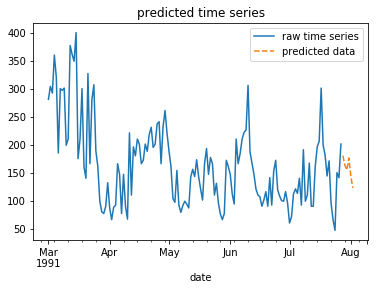

In [21]:
date_parse=lambda dates:pd.datetime.strptime(dates,'%m-%d-%Y')
df=pd.read_table('/Users/magictavern/Boyu/python_book/chapter4/time_series.txt',
                delimiter='\t',index_col='date',date_parser=date_parse)
ts_data=df['number'].astype('float32')
print ('data summary')
print (ts_data.describe())
adf,pvalue1,critical_values=adf_val(ts_data,'raw time series','raw acf','raw pacf')
pvalue2=acorr_val(ts_data)
rule1=(adf<critical_values['1%'] and adf < critical_values['5%'] and adf<critical_values['10%'] and pvalue1<0.01)
rule2=(pvalue2[0,]<0.05)
log_n,ts_data=get_best_log(ts_data,max_log=5,rule1=rule1,rule2=rule2)
adf,pvalue1,critical_values=adf_val(ts_data,'final time series','final acf','final pacf')
pvalue2=acorr_val(ts_data)
model_arma=arma_fit(ts_data)
ts_data=train_test(model_arma,ts_data,log_n,rule1=rule1,rule2=rule2)
start='1991-07-28'
end='1991-08-02'
predict_data(model_arma,ts_data,log_n,start,end,rule1=rule1,rule2=rule2)